In [1]:
!pip install datasets
!pip install -q bitsandbytes accelerate loralib datasets
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

In [2]:
import os

from training_utils import (
    run_job
)

STARTED
starting run: 0
loading model
finished loading model
loading data


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


finished loading data
training model
Epoch 1, Total Loss: 5.875574566423893
Epoch 2, Total Loss: 5.419933453202248
Epoch 3, Total Loss: 4.187236282974482
Epoch 4, Total Loss: 1.9473936958238482
Epoch 5, Total Loss: 0.781324447132647
Epoch 6, Total Loss: 0.48902223259210587
Epoch 7, Total Loss: 0.40133355278521776
Epoch 8, Total Loss: 0.2887048586271703
Epoch 9, Total Loss: 0.2159827018622309
Epoch 10, Total Loss: 0.17147077014669776
Epoch 11, Total Loss: 0.16531798476353288
Epoch 12, Total Loss: 0.1451706935185939
Epoch 13, Total Loss: 0.1507467976771295
Epoch 14, Total Loss: 0.15087244485039264
Epoch 15, Total Loss: 0.1346312378300354
Epoch 16, Total Loss: 0.13011347455903888
Epoch 17, Total Loss: 0.15971217246260494
Epoch 18, Total Loss: 0.12736810301430523
Epoch 19, Total Loss: 0.11990992550272495
Epoch 20, Total Loss: 0.13209760130848736
Total loss : 0.006604880065424368


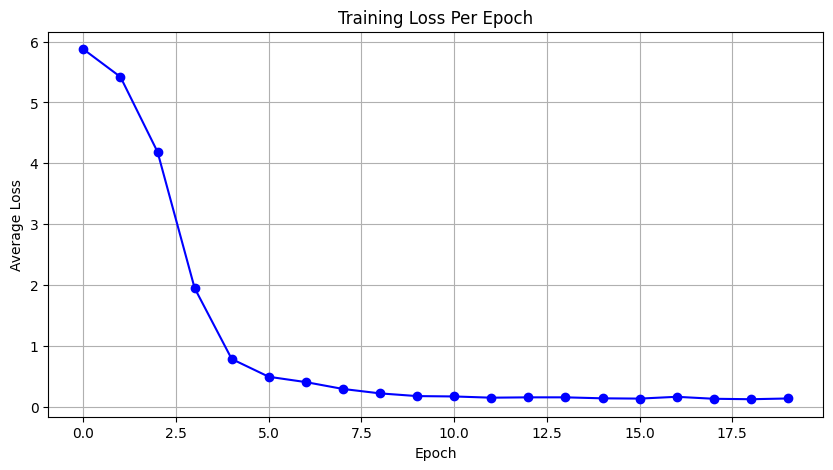

finished training model
predicting teacher on validation set
finished run in-domain teacher val0
final result 0.59375
predicting in-domain on validation set


C:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


finished run in-domain val0
final result 0.6
predicting on hans


C:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


finished run ood 0
final result 0.5
FINISHED
STARTED
starting run: 0
loading model
finished loading model
loading data
finished loading data
training model
Epoch 1, Total Loss: 6.322531394660473
Epoch 2, Total Loss: 6.024709299206734
Epoch 3, Total Loss: 4.5862963534891605
Epoch 4, Total Loss: 1.8054327238351107
Epoch 5, Total Loss: 0.7297801673412323
Epoch 6, Total Loss: 0.47752632526680827
Epoch 7, Total Loss: 0.4095894265919924
Epoch 8, Total Loss: 0.2903398829512298
Epoch 9, Total Loss: 0.25276427040807903
Epoch 10, Total Loss: 0.1925557068316266
Epoch 11, Total Loss: 0.19523968663997948
Epoch 12, Total Loss: 0.1623139635194093
Epoch 13, Total Loss: 0.1597044689115137
Epoch 14, Total Loss: 0.13937177567277104
Epoch 15, Total Loss: 0.12375278340186924
Epoch 16, Total Loss: 0.12835285591427237
Epoch 17, Total Loss: 0.14445492008235306
Epoch 18, Total Loss: 0.11393354565370828
Epoch 19, Total Loss: 0.11843552405480295
Epoch 20, Total Loss: 0.10278173082042485
Total loss : 0.0051390865

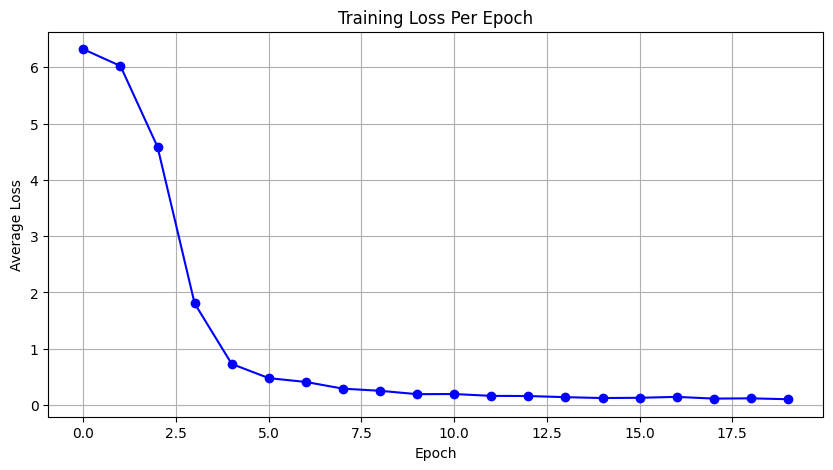

finished training model
predicting teacher on validation set
finished run in-domain teacher val0
final result 0.53125
predicting in-domain on validation set


C:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


finished run in-domain val0
final result 0.59
predicting on hans


C:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


finished run ood 0
final result 0.47
FINISHED
STARTED
starting run: 0
loading model
finished loading model
loading data
finished loading data
training model
Epoch 1, Total Loss: 6.9769100695848465
Epoch 2, Total Loss: 6.656642481684685
Epoch 3, Total Loss: 4.8269976787269115
Epoch 4, Total Loss: 2.289554290473461
Epoch 5, Total Loss: 0.8614849122241139


KeyboardInterrupt: 

In [3]:
# Models "opt-125m", "opt-350m", "opt-1.3b", "opt-2.6b"
# Datasets "mnli", "rte", "qqp"
runs = 4
dataset_used = 'mnli'
model_name = "opt-125m"
epochs = 20
val_len = 100
train_len = 32

for seed in range(runs):
    for context_len in [2,16,32]:
        print("STARTED")
        torch.cuda.empty_cache()
        job_complete_file = f'{dataset_used}_{model_name}_{seed}_out_{epochs}_{val_len}_{train_len}_{context_len}.json'
        job_complete_loc = os.path.join('output',job_complete_file)
        if os.path.exists(job_complete_loc):
            print(f"already processed file: {job_complete_file}")
        else:
          run_job(dataset_used, model_name, epochs, val_len, train_len, context_len, seed)
        print("FINISHED")

In [ ]:
from google.colab import files

!zip -r output.zip output
files.download("/content/output.zip")